# 3. Unconfined Aquifer Test - Anisotropic unconfined aquifer
The description and data for this example are taken from the [aqtesolve](http://www.aqtesolv.com/examples/ione.htm) website. 

Lohman (1972) presented data from a constant-rate pumping test performed in an unconfined aquifer with delayed gravity response near Ione, Colorado. The thickness of the unconfined alluvium was 39.4 ft. The fully penetrating test well pumped at a rate of 1170 gallons-per-minute (gpm) for 4270 minutes. The drawdown data were recorded in an observation well  located 63 ft from the test well at a depth of 19.7 ft below the static water surface.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import ttim

In [2]:
# problem definition
H = 39.4 * 0.3048  # thickness [meters]
xw, yw = 0, 0  # location well
xp, yp = 63 * 0.3048, 0  # Location piezometer [meter]
Qw = 1170 * 5.45  # discharge well in [m3/d]
z_obswell = -19.7 * 0.3048  # elevation of observation well

In [3]:
# loading data
data = np.loadtxt("./data/pumptest_neuman.txt")  # time and drawdown
time, dd = data[:, 0], data[:, 1]
td = time / 60 / 24  # t in [days]
ho = -dd * 0.3048  # observed head [meter]
print("minimum and maximum time:", td.min(), td.max())

minimum and maximum time: 0.0006944444444444445 2.965277777777778


In [4]:
# layer definition
nlay = 12  # number of layers
zlayers = np.linspace(0, -H, nlay + 1)
zcenter = 0.5 * (zlayers[:-1] + zlayers[1:])
layer_obswell = np.argmin(np.abs(z_obswell - zcenter))

Flow is simulated with a quasi three-dimensional model consisting of one aquifer which is divided into `nlay` model layers. The top and bottom of the aquifer are impermeable. The horizontal hydraulic conductivity $k$, phreatic storage $S_y$, elastic storage $S_s$, and vertical anisotropy $k_v/k_h$ are unkonwn. The variable `p` contains all unknown parameters. The well is modeled with the `Well` element. TTim divides the discharge along the layers such that the head is the same at the well in all screened layers.

In [5]:
Saq = 1e-4 * np.ones(nlay)
Saq[0] = 0.2
ml = ttim.Model3D(
    kaq=10, z=zlayers, Saq=Saq, kzoverkh=0.2, phreatictop=True, tmin=1e-4, tmax=10
)
w = ttim.Well(ml, xw=xw, yw=yw, rw=0.3, tsandQ=[(0, Qw)], layers=range(nlay))
ml.solve()

self.neq  12
solution complete


In [ ]:
cal = ttim.Calibrate(ml)
cal.set_parameter(name="kaq0_11", layers=np.arange(12), initial=100, pmin=10, pmax=400)
cal.set_parameter(name="Saq0", layers=0, initial=0.1, pmin=0.01, pmax=1)
cal.set_parameter(
    name="Saq1_11", layers=np.arange(1, 12), initial=1e-4, pmin=1e-5, pmax=1e-3
)
cal.set_parameter_by_reference(
    name="kzoverkh", parameter=ml.aq.kzoverkh[:], initial=0.2, pmin=0.01, pmax=1
)
cal.series(name="obs1", x=xp, y=yp, layer=layer_obswell, t=td, h=ho)
cal.fit()

.................................................................
Fit succeeded.


In [7]:
# cal.parameters
k, Sy, Ss, kzoverkh = cal.parameters["optimal"].values

Text(0.5, 0.98, 'TTim Aquifer Test Analysis in Unconfined Aquifer')

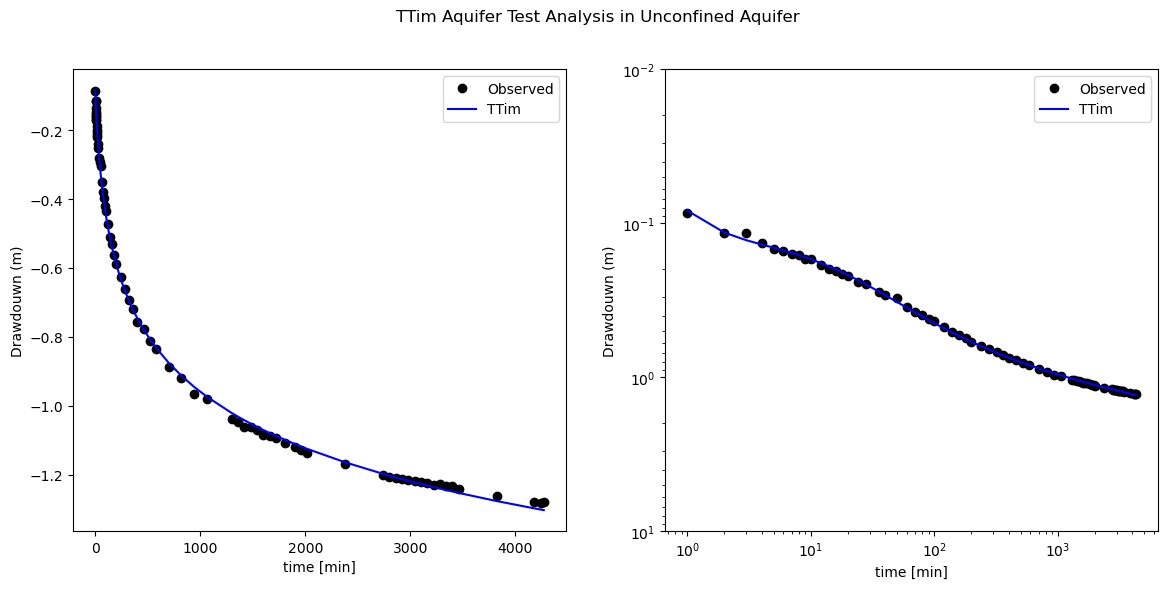

In [8]:
hm1 = ml.head(xp, yp, td, layers=layer_obswell)
plt.figure(figsize=(14, 6))
plt.subplot(121)
plt.plot(time, ho, "ko", label="Observed")
plt.plot(time, hm1[0], "b", label="TTim")
plt.xlabel("time [min]")
plt.ylabel("Drawdouwn (m)")
plt.legend(loc="best")
plt.subplot(122)
plt.loglog(time, -ho, "ko", label="Observed")
plt.loglog(time, -hm1[0], "b", label="TTim")
plt.ylim(10, 0.01)
plt.xlabel("time [min]")
plt.ylabel("Drawdouwn (m)")
plt.legend(loc="best")
plt.suptitle("TTim Aquifer Test Analysis in Unconfined Aquifer")

In [9]:
r = pd.DataFrame(
    columns=["$T$ [ft$^2$/day]", "$S_y$", "$S$", "$k_h/k_r$"],
    index=["Lohman (1972)", "AQTESOLV", "TTim"],
)
r.loc["Lohman (1972)"] = [22000, 0.2, 0, 0.3]
r.loc["AQTESOLV"] = [22980, 0.15, 0.008166, 0.25]
r.loc["TTim"] = [k * H / 0.0929, Sy, Ss * H, kzoverkh]
r

,$T$ [ft$^2$/day],$S_y$,$S$,$k_h/k_r$
Lohman (1972),22000,0.2,0,0.3
AQTESOLV,22980,0.15,0.008166,0.25
TTim,22920.150704,0.15726,0.005939,0.186627


This model is similar to the first model except for the `Well` function. Here, a `DischargeWell` is used and the discharge is evenly divided over all the layers. 

In [ ]:
ml = ttim.Model3D(
    kaq=10, z=zlayers, Saq=Saq, kzoverkh=0.2, phreatictop=True, tmin=1e-4, tmax=10
)
Qp = Qw / nlay  # deviding Qw over the layers equal
w = ttim.DischargeWell(ml, xw=xw, yw=yw, rw=0.3, tsandQ=[(0, Qp)], layers=range(nlay))
ml.solve()
cal = ttim.Calibrate(ml)
cal.set_parameter(name="kaq0_11", layers=np.arange(12), initial=100, pmin=10, pmax=400)
cal.set_parameter(name="Saq0", layers=0, initial=0.1, pmin=0.01, pmax=1)
cal.set_parameter(
    name="Saq1_11", layers=np.arange(1, 12), initial=1e-4, pmin=1e-5, pmax=1e-3
)
cal.set_parameter_by_reference(
    name="kzoverkh", parameter=ml.aq.kzoverkh[:], initial=0.2, pmin=0.01, pmax=1
)
cal.series(name="obs1", x=xp, y=yp, layer=layer_obswell, t=td, h=ho)
cal.fit()

self.neq  0
No unknowns. Solution complete
..............................................................
Fit succeeded.


In [11]:
# cal.parameters
k, Sy, Ss, kzoverkh = cal.parameters["optimal"].values
r.loc["TTim uniform discharge well"] = [k * H / 0.0929, Sy, Ss * H, kzoverkh]
r

,$T$ [ft$^2$/day],$S_y$,$S$,$k_h/k_r$
Lohman (1972),22000,0.2,0,0.3
AQTESOLV,22980,0.15,0.008166,0.25
TTim,22920.150704,0.15726,0.005939,0.186627
TTim uniform discharge well,23009.997954,0.153123,0.007875,0.197499
